### Data Processing

In [1]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Import NY later
listings = pd.read_csv('Data/New_York_City.csv')

C:\Users\jyesu_000\anaconda3\envs\PythonData38\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Add city column
listings['city'] = 'New York City'
listings.tail()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city
37405,6.406120e+17,https://www.airbnb.com/rooms/640612171111039003,2.022060e+13,6/4/22,2nd Floor near Park and Ferry to NYC,NaN,NaN,https://a0.muscache.com/pictures/255e6d38-ce3f...,32162495,https://www.airbnb.com/users/show/32162495,...,NaN,NaN,NaN,f,3,3,0,0,NaN,New York City
37406,6.406300e+17,https://www.airbnb.com/rooms/640629990855220048,2.022060e+13,6/4/22,Empire House by Rove | Modern Williamsburg 3 B...,**New photos of new bedding arrangements and h...,NaN,https://a0.muscache.com/pictures/prohost-api/H...,404940500,https://www.airbnb.com/users/show/404940500,...,NaN,NaN,NaN,f,5,5,0,0,NaN,New York City
37407,6.406580e+17,https://www.airbnb.com/rooms/640658348674867448,2.022060e+13,6/4/22,Private room with Shared bath on Union Square 5,Thank you for your interest.<br />Who do you r...,NaN,https://a0.muscache.com/pictures/prohost-api/H...,408979935,https://www.airbnb.com/users/show/408979935,...,NaN,NaN,NaN,t,16,0,16,0,NaN,New York City
37408,6.410720e+17,https://www.airbnb.com/rooms/641072234133563797,2.022060e+13,6/4/22,"Bright East Village 1BR w/ W/D, on prime corne...",Show up and start living from day one in Downt...,This rental is located in NYC’s East Village. ...,https://a0.muscache.com/pictures/prohost-api/H...,107434423,https://www.airbnb.com/users/show/107434423,...,NaN,NaN,NaN,t,391,391,0,0,NaN,New York City
37409,6.412410e+17,https://www.airbnb.com/rooms/641241352138040023,2.022060e+13,6/4/22,"Rest, Relax & Recharge! Club Wyndham Midtown 4...",With a majestic location from which to experie...,NaN,https://a0.muscache.com/pictures/prohost-api/H...,355450429,https://www.airbnb.com/users/show/355450429,...,NaN,NaN,NaN,f,4,4,0,0,NaN,New York City


In [4]:
# See all columns in merged dataset
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [5]:
# Identify columns with null values exceeding 1500
null_check = listings.isna().sum()
remove_column_indices = []
remove_columns = []
[remove_columns.append(null_check.index[i]) for i in range(len(null_check)) if null_check[i] > 1500]
remove_columns

['neighborhood_overview',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_neighbourhood',
 'neighbourhood',
 'bathrooms',
 'bedrooms',
 'calendar_updated',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'license',
 'reviews_per_month']

In [6]:
# Check columns with most null values
null_check.sort_values(ascending=False).head(20)

calendar_updated               37410
bathrooms                      37410
license                        37406
host_about                     16356
neighborhood_overview          14980
neighbourhood                  14979
host_response_rate             13210
host_response_time             13210
host_acceptance_rate           11732
review_scores_value             8435
review_scores_location          8435
review_scores_checkin           8432
review_scores_accuracy          8428
review_scores_communication     8423
review_scores_cleanliness       8418
review_scores_rating            7949
last_review                     7949
first_review                    7949
reviews_per_month               7949
host_neighbourhood              7542
dtype: int64

In [7]:
# Drop all rows with null values
# listings.dropna(inplace=True)

In [8]:
# Convert t/f to 1/0
listings['host_is_superhost'] = listings['host_is_superhost']\
                                .apply(lambda value: 1 if value == 't' else 0)

listings['instant_bookable'] = listings['instant_bookable']\
                                .apply(lambda value: 1 if value == 't' else 0)
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city
0,2595.0,https://www.airbnb.com/rooms/2595,2.022060e+13,6/4/22,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,...,4.86,4.41,NaN,0,3,3,0,0,0.31,New York City
1,5121.0,https://www.airbnb.com/rooms/5121,2.022060e+13,6/4/22,BlissArtsSpace!,One room available for rent in a 2 bedroom apt...,NaN,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,...,4.47,4.52,NaN,0,2,0,2,0,0.32,New York City
2,5136.0,https://www.airbnb.com/rooms/5136,2.022060e+13,6/4/22,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,7378,https://www.airbnb.com/users/show/7378,...,4.50,5.00,NaN,0,1,1,0,0,0.02,New York City
3,5178.0,https://www.airbnb.com/rooms/5178,2.022060e+13,6/4/22,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",https://a0.muscache.com/pictures/12065/f070997...,8967,https://www.airbnb.com/users/show/8967,...,4.87,4.39,NaN,0,1,0,1,0,3.37,New York City
4,5203.0,https://www.airbnb.com/rooms/5203,2.022060e+13,6/3/22,Cozy Clean Guest Room - Family Apt,"Our best guests are seeking a safe, clean, spa...",Our neighborhood is full of restaurants and ca...,https://a0.muscache.com/pictures/103776/b37157...,7490,https://www.airbnb.com/users/show/7490,...,4.94,4.92,NaN,0,1,0,1,0,0.76,New York City


In [9]:
# Convert price variable to float
listings['price_int'] = listings['price'].str.replace('$', '')
listings['price_int'] = listings['price_int'].str.replace(',', '')
listings['price_int'] = listings['price_int'].astype(float)
listings['price_int'].dtype

C:\Users\JYESU_~1\AppData\Local\Temp/ipykernel_5372/1379668244.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  listings['price_int'] = listings['price'].str.replace('$', '')


dtype('float64')

In [10]:
# Convert host acceptance rate from string to float
listings['host_acceptance_rate'] = listings['host_acceptance_rate']\
                                .str.replace('%', '').astype(float)

listings['host_acceptance_rate'].dtype

dtype('float64')

In [11]:
# Distinguish between long-term and short-term rentals
listings.loc[listings['minimum_nights'] < 30, 'short-term'] = 1
listings.loc[listings['minimum_nights'] >= 30, 'short-term'] = 0

In [12]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [13]:
model_data = pd.DataFrame(listings[['host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'short-term',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'number_of_reviews', 'neighbourhood_group_cleansed',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms',
       'city', 'price_int']])

In [14]:
# Create bins for the number of reviews that a listing has
model_data.loc[model_data['number_of_reviews'] == 0, 'review_count_bin'] = 'No reviews'
model_data.loc[(model_data['number_of_reviews'] > 0) \
               & (model_data['number_of_reviews'] < 10), 'review_count_bin'] = 'Less than 10'
model_data.loc[(model_data['number_of_reviews'] >= 10) \
               & (model_data['number_of_reviews'] < 50), 'review_count_bin'] = 'Between 10 and 50'
model_data.loc[(model_data['number_of_reviews'] >= 50) \
               & (model_data['number_of_reviews'] < 200), 'review_count_bin'] = 'Between 50 and 200'
model_data.loc[model_data['number_of_reviews'] >= 200, 'review_count_bin'] = '200 or greater'

In [15]:
# Checks whether listing has A/C or a washer/dryer and adds dummy columns

# Initialize empty lists
air_conditioning = []
washer_dryer = []
num_amenities = []

# Loops through each listing's amenities to look for air conditioning or washer/dryer
listings_amenities = list(model_data['amenities'])
for amenities in listings_amenities:
    amenities = amenities.replace('"','')
    amenities_list = amenities.split(', ')
    air_check = [1 if item == 'Air conditioning' else 0 for item in amenities_list]
    air_conditioning.append(max(air_check))
    laundry_check = [1 if (item == 'Washer' or item == 'Dryer') else 0 for item in amenities_list]
    washer_dryer.append(max(laundry_check))
    num_amenities.append(len(amenities_list))

# Creates dataframe columns
model_data['air_conditioning'] = pd.Series(air_conditioning)
model_data['washer_dryer'] = pd.Series(washer_dryer)
model_data['num_amenities'] = pd.Series(num_amenities)

In [16]:
model_data['bedrooms_per_accomodates'] = model_data['bedrooms'] / model_data['accommodates']

In [17]:
# Summarize model data
# model_data.dropna(inplace=True)
model_data.describe()

,host_acceptance_rate,host_is_superhost,host_listings_count,short-term,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,price_int,air_conditioning,washer_dryer,num_amenities,bedrooms_per_accomodates
count,25678.000000,37410.000000,37344.000000,37410.000000,37344.000000,37410.000000,37410.000000,37410.000000,33756.000000,36509.000000,...,37410.000000,37410.000000,37410.000000,37410.000000,37410.000000,37410.000000,37410.000000,37410.000000,37410.000000,33756.000000
mean,81.533297,0.183186,63.811509,0.495643,63.811509,40.729308,-73.946171,2.904918,1.354219,1.634720,...,0.267469,15.114782,9.396685,5.600508,0.051270,190.775221,0.762122,0.336300,24.108768,0.549284
std,26.593832,0.386824,400.332606,0.499988,400.332606,0.058041,0.056701,1.964525,0.734038,1.148007,...,0.442645,50.717311,45.421795,23.806312,0.492768,342.491748,0.425789,0.472449,12.942946,0.280437
min,0.000000,0.000000,0.000000,0.000000,0.000000,40.504560,-74.269520,0.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.062500
25%,75.000000,0.000000,1.000000,0.000000,1.000000,40.688260,-73.983518,2.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,75.000000,1.000000,0.000000,14.000000,0.400000
50%,94.000000,0.000000,1.000000,0.000000,1.000000,40.724885,-73.953794,2.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,125.000000,1.000000,0.000000,22.000000,0.500000
75%,100.000000,0.000000,3.000000,1.000000,3.000000,40.763380,-73.926340,4.000000,1.000000,2.000000,...,1.000000,3.000000,1.000000,1.000000,0.000000,203.000000,1.000000,1.000000,32.000000,0.500000
max,100.000000,1.000000,3404.000000,1.000000,3404.000000,40.928340,-73.693210,16.000000,15.000000,42.000000,...,1.000000,391.000000,391.000000,190.000000,11.000000,12900.000000,1.000000,1.000000,96.000000,6.000000


In [18]:
# listings.to_csv('Data/Consolidated_Data.csv')

### Data Investigation and Outlier Identification

In [19]:
# Check average price and count of listings by neighborhood
avg_price_by_neighborhood = listings.groupby(by=['neighbourhood_cleansed'])['price_int']\
                    .agg(['mean','count'])
avg_price_by_neighborhood = pd.DataFrame(avg_price_by_neighborhood)
avg_price_by_neighborhood.sort_values(['count'],ascending=True).head(20)

,mean,count
neighbourhood_cleansed,,
Rossville,75.000000,1
South Beach,95.000000,1
Westerleigh,94.000000,1
Bloomfield,175.000000,1
Pelham Islands,250.000000,1
Willowbrook,309.000000,1
Fort Wadsworth,700.000000,1
Woodrow,99.000000,1
LaGuardia Airport,188.000000,1


In [20]:
# Find neighborhoods with greater than 5 listings
neighborhoods_retain = avg_price_by_neighborhood.loc[avg_price_by_neighborhood['count'] > 5]

In [21]:
# Check distribution of number of reviews
model_data.groupby(by=['review_count_bin'])['price_int']\
                    .agg(['mean','count'])

,mean,count
review_count_bin,,
200 or greater,150.970552,815
Between 10 and 50,179.674027,9375
Between 50 and 200,166.186503,4890
Less than 10,177.938600,14381
No reviews,246.298780,7949


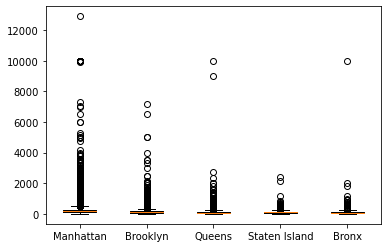

In [22]:
# Assemble boxplot data for plotting prices per burrough
burroughs = list(listings['neighbourhood_group_cleansed'].unique())

boxplot_data = []
for burrough in burroughs:
#     burrough_data = listings.loc[listings['neighbourhood_group_cleansed'] == burrough]
    burrough_data = model_data.loc[model_data['neighbourhood_group_cleansed'] == burrough]
    boxplot_data.append(burrough_data['price_int'])
    
# Price by burrough
plt.boxplot(boxplot_data,labels=burroughs);

In [23]:
# Determine max price by burrough and calculate 50% of max price
max_price_by_burrough = pd.DataFrame(listings.groupby(by='neighbourhood_group_cleansed',
                                                     as_index = False)
                                     ['price_int'].max())
max_price_by_burrough['price_cutoff'] = max_price_by_burrough['price_int'] / 2
max_price_by_burrough.rename(columns={'price_int' : 'max_burrough_price'},inplace=True)

In [24]:
# Check average price and count of listings by neighborhood
price_by_type = listings.groupby(by=['property_type'])['price_int']\
                    .agg(['mean','count'])
price_by_type = pd.DataFrame(price_by_type)
price_by_type.sort_values(['count'],ascending=True).head(40)
drop_property_types = price_by_type.loc[price_by_type['count'] <= 5].index
list(drop_property_types)

['Barn',
 'Castle',
 'Cave',
 'Entire bed and breakfast',
 'Lighthouse',
 'Private room in barn',
 'Private room in boat',
 'Private room in camper/rv',
 'Private room in cottage',
 'Private room in dorm',
 'Private room in farm stay',
 'Private room in floor',
 'Private room in in-law',
 'Private room in lighthouse',
 'Private room in minsu',
 'Private room in ranch',
 'Private room in religious building',
 'Private room in tent',
 'Private room in tiny home',
 'Private room in train',
 'Room in bed and breakfast',
 'Room in resort',
 'Shared room',
 'Shared room in bed and breakfast',
 'Shared room in bungalow',
 'Shared room in floor',
 'Shared room in guest suite',
 'Shared room in guesthouse',
 'Shared room in hostel',
 'Shared room in serviced apartment',
 'Shared room in townhouse',
 'Shared room in vacation home',
 'Tent',
 'Tower']

In [25]:
# Check average price and count of listings by neighborhood
price_by_rooms = listings.groupby(by=['bedrooms'])['price_int']\
                    .agg(['mean','count'])
price_by_rooms = pd.DataFrame(price_by_rooms)
price_by_rooms.sort_values(['count'],ascending=True).head()

,mean,count
bedrooms,,
10.0,1643.0,1
11.0,66.0,1
13.0,412.0,1
14.0,2029.0,1
15.0,1590.0,1


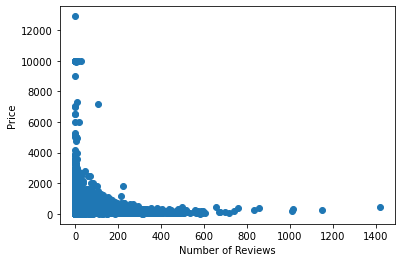

In [26]:
plt.scatter(x=listings['number_of_reviews'],y=listings['price_int']);
plt.xlabel('Number of Reviews');
plt.ylabel('Price');

### Outlier Removal

In [27]:
# Remove listings with more than 10 rooms
model_data = model_data.loc[model_data['bedrooms'] <= 10]

# Remove listings with a minimum stay greater than a year
model_data = model_data.loc[model_data['minimum_nights'] < 365]

In [28]:
# Remove listings for property types with count less than 6
model_data = model_data[~model_data['property_type'].isin(drop_property_types)]

In [29]:
# Remove listings at a price that exceeds 50% of the max price for each burrough
model_data = pd.merge(model_data,max_price_by_burrough,how='left',on='neighbourhood_group_cleansed')
model_data = model_data.loc[model_data['price_int'] < model_data['price_cutoff']]
model_data.head()

,host_acceptance_rate,host_is_superhost,host_listings_count,short-term,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,...,calculated_host_listings_count_shared_rooms,city,price_int,review_count_bin,air_conditioning,washer_dryer,num_amenities,bedrooms_per_accomodates,max_burrough_price,price_cutoff
0,100.0,0,1.0,0.0,1.0,"['email', 'phone']",t,t,Bedford-Stuyvesant,40.68535,...,0,New York City,60.0,Between 50 and 200,1,0,5,0.5,7184.0,3592.0
1,50.0,0,1.0,1.0,1.0,"['email', 'phone']",t,t,Sunset Park,40.66265,...,0,New York City,275.0,Less than 10,1,1,22,0.5,7184.0,3592.0
2,100.0,0,1.0,1.0,1.0,"['email', 'phone']",t,f,Midtown,40.76457,...,0,New York City,68.0,200 or greater,1,0,25,0.5,12900.0,6450.0
3,NaN,0,1.0,1.0,1.0,"['email', 'phone']",t,t,Upper West Side,40.80380,...,0,New York City,75.0,Between 50 and 200,1,0,15,1.0,12900.0,6450.0
4,60.0,1,3.0,0.0,3.0,"['email', 'phone']",t,t,Morningside Heights,40.80316,...,0,New York City,135.0,Between 50 and 200,1,0,15,0.5,12900.0,6450.0


In [30]:
model_data = model_data.loc[model_data['number_of_reviews'] > 20]

### Modeling

#### Linear Model

In [31]:
# initialize empty list to store linear model results
results_tracker = []

def linear_model(data):
    # Removes any lingering null values - may need to rethink location of this
    data.dropna(inplace=True)
    # Assign X and y
    y = data['price_int']
    X = data.drop(columns='price_int').values

    # Split the data into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

    # Instantiate and train the model
    reg = LinearRegression()
    reg.fit(X_train,y_train)
    reg.score(X_train,y_train)
    
    print(f'Train score:\t {reg.score(X_train,y_train)}')
    print(f'Test score:\t {reg.score(X_test,y_test)}')
    
    # Save the results into the results_tracker
    results = {'train score' : reg.score(X_train,y_train),
              'test score' : reg.score(X_test,y_test),
              'features' : list(data.columns)}
    results_tracker.append(results)

#### Run Linear Models

In [32]:
model_data_1 = model_data[['price_int','bedrooms','accommodates']]

In [33]:
linear_model(model_data_1)

Train score:	 0.26132403127931614
Test score:	 0.26583337414853403


C:\Users\jyesu_000\anaconda3\envs\PythonData38\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [34]:
model_data_2 = model_data[['price_int','accommodates','review_scores_rating']]

In [35]:
linear_model(model_data_2)

Train score:	 0.24806800596697298
Test score:	 0.26804330195316206


C:\Users\jyesu_000\anaconda3\envs\PythonData38\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [36]:
model_data_3 = model_data[['host_is_superhost','room_type', 'accommodates','bedrooms','number_of_reviews', 
                   'review_scores_rating','city', 'price_int']]
model_data_3 = pd.get_dummies(model_data_3)

In [37]:
linear_model(model_data_3)

Train score:	 0.2938030630620382
Test score:	 0.29156977018228725


In [38]:
model_data_4 = pd.get_dummies(model_data[['price_int','review_count_bin','review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin', 'number_of_reviews','host_acceptance_rate',
       'review_scores_communication', 'review_scores_location', 'instant_bookable',
       'review_scores_value','host_is_superhost','accommodates','bedrooms','review_scores_rating','room_type']])

In [39]:
linear_model(model_data_4)

Train score:	 0.40811148149547527
Test score:	 0.38343546568723685


In [40]:
model_data_5 = pd.get_dummies(model_data[['price_int','city','accommodates', 'bedrooms',
                                          'review_scores_rating','number_of_reviews',
                                          'host_is_superhost','instant_bookable','room_type']])

In [41]:
linear_model(model_data_5)

Train score:	 0.2942266807372744
Test score:	 0.2916297951723853


In [42]:
model_data_6 = pd.get_dummies(model_data[['price_int','neighbourhood_group_cleansed',
                                          'accommodates', 'bedrooms', 'air_conditioning',
                                          'review_scores_rating','review_count_bin',
                                          'host_is_superhost','host_identity_verified','room_type']])

In [43]:
linear_model(model_data_6)

Train score:	 0.37275130270822143
Test score:	 0.37221349576975316


In [44]:
model_data_7 = pd.get_dummies(model_data[['host_is_superhost','room_type', 'accommodates','bedrooms','number_of_reviews', 
                   'review_scores_rating','price_int','neighbourhood_group_cleansed']])

In [45]:
linear_model(model_data_7)

Train score:	 0.3709479611424369
Test score:	 0.36983561961511824


In [46]:
model_data_8 = pd.get_dummies(model_data[['price_int','neighbourhood_group_cleansed',
       'review_scores_cleanliness','host_acceptance_rate', 'review_scores_communication',
        'review_scores_location', 'instant_bookable','short-term', 'review_scores_checkin',
       'review_scores_value','accommodates','bedrooms','review_scores_rating','room_type']])

In [47]:
linear_model(model_data_8)

Train score:	 0.4586770055163667
Test score:	 0.42240377626206627


In [48]:
model_data_9 = pd.get_dummies(model_data[['price_int','neighbourhood_group_cleansed','review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin', 'review_count_bin','host_acceptance_rate',
       'review_scores_communication', 'review_scores_location', 'instant_bookable','short-term', 'air_conditioning',
       'review_scores_value','host_is_superhost','accommodates','bedrooms','review_scores_rating','room_type']])

In [49]:
linear_model(model_data_9)

Train score:	 0.4596519469884658
Test score:	 0.42339181255280056


In [50]:
model_data_10 = pd.get_dummies(model_data[['price_int', 'neighbourhood_group_cleansed',
                                           'review_count_bin', 'air_conditioning','accommodates',
                                           'instant_bookable', 'short-term', 'num_amenities',
                                           'host_identity_verified', 'bedrooms', 'bedrooms_per_accomodates',
                                           'room_type']])

In [51]:
linear_model(model_data_10)

Train score:	 0.3741216880683057
Test score:	 0.36472746082923513


In [52]:
model_data_11 = pd.get_dummies(model_data[['price_int','neighbourhood_group_cleansed',
       'review_scores_cleanliness', 'review_count_bin', 'air_conditioning',
        'review_scores_location', 'instant_bookable','short-term', 'accommodates',
       'review_scores_value','review_scores_rating','room_type']])

In [53]:
linear_model(model_data_11)

Train score:	 0.3937571554108682
Test score:	 0.4081709834236543


#### Review Results

In [54]:
# Remove duplicates from results_tracker and sort results in order of best training score
results_summary = []
[results_summary.append(x) for x in results_tracker if x not in results_summary]
results_summary.sort(key=lambda result: result['train score'],reverse=True)

# Print best result
print(f'Best training score: {results_summary[0]["train score"]}')
print(f'Number of features: {len(results_summary[0]["features"])}')
print(f'Best features: {results_summary[0]["features"]}')

Best training score: 0.4596519469884658
Number of features: 27
Best features: ['price_int', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'host_acceptance_rate', 'review_scores_communication', 'review_scores_location', 'instant_bookable', 'short-term', 'air_conditioning', 'review_scores_value', 'host_is_superhost', 'accommodates', 'bedrooms', 'review_scores_rating', 'neighbourhood_group_cleansed_Bronx', 'neighbourhood_group_cleansed_Brooklyn', 'neighbourhood_group_cleansed_Manhattan', 'neighbourhood_group_cleansed_Queens', 'neighbourhood_group_cleansed_Staten Island', 'review_count_bin_200 or greater', 'review_count_bin_Between 10 and 50', 'review_count_bin_Between 50 and 200', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room']


In [55]:
print(results_summary[1]['features'])

['price_int', 'review_scores_cleanliness', 'host_acceptance_rate', 'review_scores_communication', 'review_scores_location', 'instant_bookable', 'short-term', 'review_scores_checkin', 'review_scores_value', 'accommodates', 'bedrooms', 'review_scores_rating', 'neighbourhood_group_cleansed_Bronx', 'neighbourhood_group_cleansed_Brooklyn', 'neighbourhood_group_cleansed_Manhattan', 'neighbourhood_group_cleansed_Queens', 'neighbourhood_group_cleansed_Staten Island', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room']


In [56]:
model_data['accommodates'].unique().max()

16

#### Random Forest Regressor

In [57]:
rfr_results_tracker = []

def random_forests(data):
    # Removes any lingering null values - may need to rethink location of this
    data.dropna(inplace=True)
    # Assign X and y
    y = data['price_int']
    X = data.drop(columns='price_int').values

    # Split the data into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=9)

    # Instantiate and train the model
    rfr = RandomForestRegressor(random_state=9)
    rfr.fit(X_train,y_train)
    rfr.score(X_train,y_train)
    
    print(f'Train score:\t {rfr.score(X_train,y_train)}')
    print(f'Test score:\t {rfr.score(X_test,y_test)}')
    
    # Save the results into the results_tracker
    results = {'train score' : rfr.score(X_train,y_train),
              'test score' : rfr.score(X_test,y_test),
              'features' : list(data.columns)}
    rfr_results_tracker.append(results)

#### Run Random Forests Models

In [58]:
random_forests(model_data_8)

Train score:	 0.9289833832511434
Test score:	 0.5143810013737884


In [59]:
random_forests(model_data_9)

Train score:	 0.9295621735042559
Test score:	 0.5090369407156238


In [60]:
random_forests(model_data_11)

Train score:	 0.9134875673953358
Test score:	 0.39932066998921634


### Run and Export Final Model

In [61]:
# Using model_data_8
data = model_data_8

# Removes any lingering null values - may need to rethink location of this
data.dropna(inplace=True)
# Assign X and y
y = data['price_int']
X = data.drop(columns='price_int').values

# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=9)

# Instantiate and train the model
rfr = RandomForestRegressor(random_state=9)
rfr.fit(X_train,y_train)
rfr.score(X_train,y_train)
    
print(f'Train score:\t {rfr.score(X_train,y_train)}')
print(f'Test score:\t {rfr.score(X_test,y_test)}')

Train score:	 0.9289833832511434
Test score:	 0.5143810013737884


In [62]:
# from joblib import dump, load
# dump(rfr, 'random_forest_model_8.joblib')

In [63]:
# Rename columns for heatmap
heatmap_data = model_data_8
heatmap_data.columns = ['Price','Cleanliness Score','Host Acceptance Rate',
                             'Communication Score', 'Location Score', 'Instant Bookable',
                             'Short-term', 'Checkin Score', 'Value Score','Accommodates',
                             'Bedrooms', 'Overall Score', 'Borough - Bronx', 'Borough - Brooklyn',
                             'Borough - Manhattan', 'Borough - Queens', 'Borough - Staten Island',
                             'Entire home', 'Hotel room', 'Private room', 'Shared room']

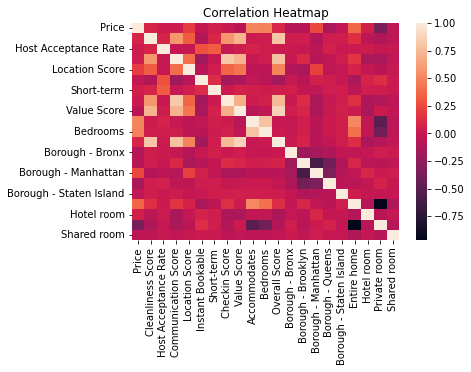

In [64]:
# Plot correlation heatmap using Seaborn
sn.heatmap(heatmap_data.corr());
plt.title('Correlation Heatmap');